In [2]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns

Text(0, 0.5, 'x, v')

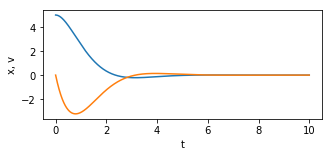

In [5]:
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

k = 2
b = 2
x0 = [5,0]
t = np.linspace(0,10,2000)
sol = odeint(fun, x0, t)

plt.figure(figsize=(5,2));
plt.plot(t,sol);
plt.xlabel('t')
plt.ylabel('x, v')

In [104]:
def CumExpDist(t,tau):
    return 1 - np.exp(-tau*t)

# Distributions Parameters
Sigma = np.array([[5,0],[0,5]])
mu = np.array([0,0])
tau = 0.4

# Compute P_space and P_time 
N = 40
u = np.linspace(-10,10,N)
v = np.linspace(-10,10,N)
T = np.linspace(0,10,N)
U,V = np.meshgrid(u,v)
#
P = np.zeros((N,N))
P_exp = np.zeros((N,1))
for i in range(N):
    for j in range(N):
        x = np.array([U[i,j],V[i,j]])
        P[i,j] = multivariate_normal.pdf(x,mu,Sigma)
    P_exp[i] = CumExpDist(T[i],tau)
    

# Compute Total Probability
X = -5 + 10*np.random.rand(10000,2)
X = np.hstack((X,5*np.random.rand(10000,1)))
#
P_tot = [multivariate_normal.pdf(x[:2],mu,Sigma)*CumExpDist(x[2],tau) for x in X]

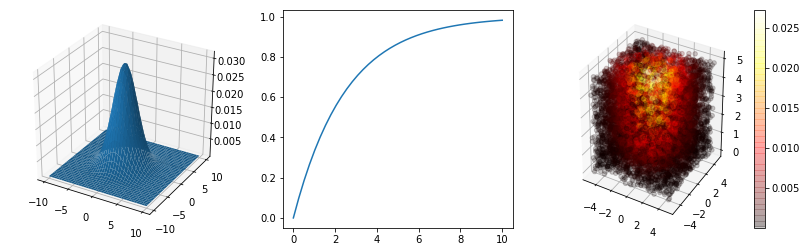

In [122]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(U, V, P)
ax2 = fig.add_subplot(132)
ax2.plot(T, P_exp)
ax3 = fig.add_subplot(133, projection='3d')
density = ax3.scatter(X[:,0], X[:,1], X[:,2], c=P_tot, cmap=plt.hot(), alpha = 0.2)
fig.colorbar(density)

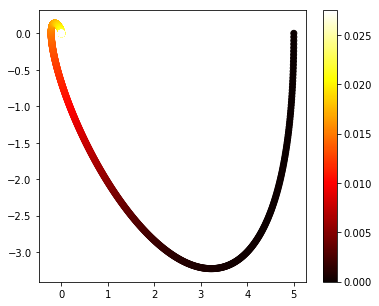

In [123]:
#
p_sol = np.array([multivariate_normal.pdf(sol[i],mu,Sigma) for i in range(len(sol))])#np.array([SpatialExpDist(sol[i],0.01) for i in range(len(sol))])#
p_t = np.array([CumExpDist(t[i],0.2) for i in range(len(sol))])
P = np.multiply(p_sol,p_t)

In [125]:
Event_flag = np.array([np.random.binomial(1,P[i]) for i in range(len(sol))])

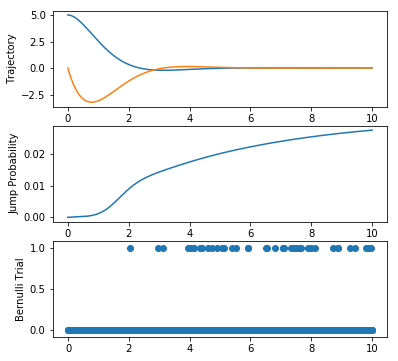

In [126]:
plt.figure(figsize=(6,6))
plt.subplot(311)
plt.plot(t,sol)
plt.ylabel('Trajectory')
plt.subplot(312)
plt.plot(t,P)
plt.ylabel('Jump Probability')
plt.subplot(313)
plt.ylabel('Bernulli Trial')
plt.scatter(t,Event_flag)

In [127]:
Event_index = []
for i in range(len(Event_flag)):
    if Event_flag[i]>0:
        Event_index.append(i)
Event_states = sol[Event_index]

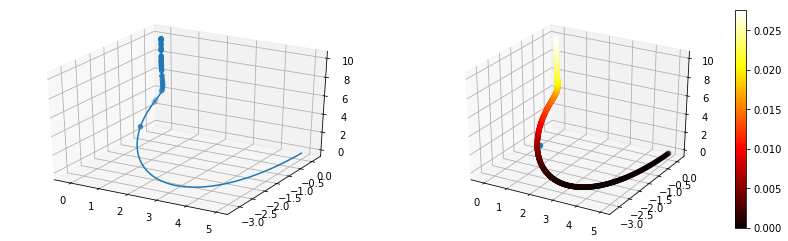

In [136]:
import matplotlib
cmap = matplotlib.cm.get_cmap('hot')
normalize = matplotlib.colors.Normalize(vmin=min(P), vmax=max(P))
colors = [cmap(normalize(value)) for value in P]

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(sol[:,0],sol[:,1],t)
ax1.scatter(Event_states[:,0],Event_states[:,1], t[Event_index].reshape(-1,1))
#
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(sol[:,0], sol[:,1], t.reshape(-1,1), color=colors)
ax2.scatter(Event_states[0,0],Event_states[0,1])
cax, _ = matplotlib.colorbar.make_axes(ax2)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)


In [134]:
#jump map
def jump(x,t):
    mu = (x + 1*np.random.randn(1,2)).tolist()
    Sigma = [[5,0],[0,5]]
    return np.random.multivariate_normal(mu[0],Sigma)

from pyPDMP.utils import HDSint
Ttot, Xtot, Xevent, Xreset, C = HDSint(5000,t,fun,x0,mu,Sigma,tau)

Progress:
25.0
50.0
75.0
100.0


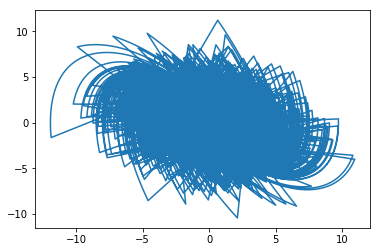

In [137]:
plt.figure()
plt.plot(Xtot[1:,0],Xtot[1:,1]);
plt.scatter(Xevent[1:,0],Xevent[1:,1]);

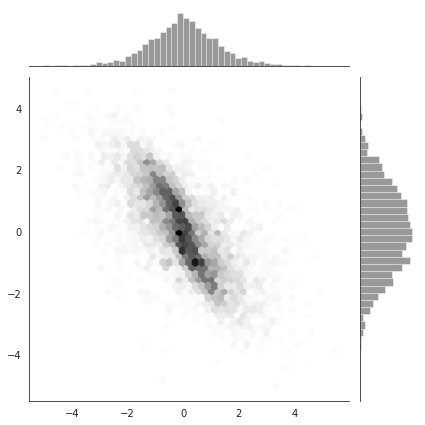

In [141]:
with sns.axes_style("white"):
    sns.jointplot(x=Xevent[:,0], y=Xevent[:,1], kind="hex", color="k");

Text(0.5, 0, 'event time')

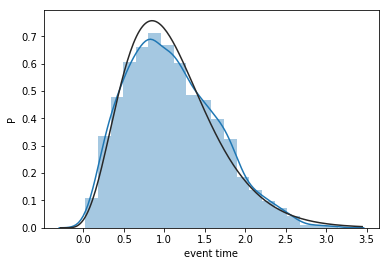

In [146]:
from scipy.stats import norm
from scipy.stats import gamma
plt.figure()
sns.distplot(Xevent[1:,2],bins = 20, fit = gamma);
plt.ylabel('P')
plt.xlabel('event time')

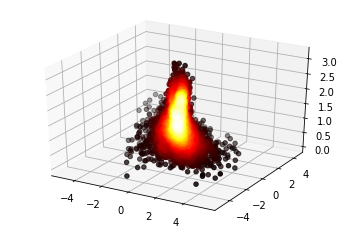

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
x = Xevent[1:,0]
y = Xevent[1:,1]
z = Xevent[1:,2]

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density,cmap=plt.hot())
plt.draw()
plt.show()

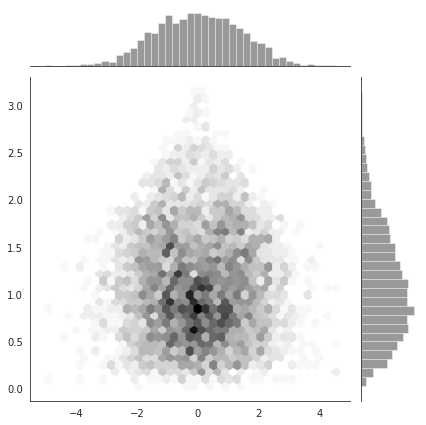

In [154]:
with sns.axes_style("white"):
        sns.jointplot(x=Xevent[1:,1], y=Xevent[1:,2], kind="hex", color="k");

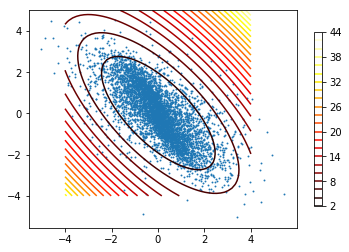

In [159]:
from matplotlib.colors import LogNorm
from sklearn import mixture

# Fit mixure of gaussian
clf = mixture.GaussianMixture(n_components=1, covariance_type='full')
clf.fit(np.hstack((Xevent[:,0].reshape(-1,1),Xevent[:,1].reshape(-1,1))))

x = np.linspace(-4., 4.)
y = np.linspace(-4., 5.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure()
CS = plt.contour(X, Y, Z,20)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(Xevent[1:,0], Xevent[1:,1], .8)
plt.show()

In [160]:
np.hstack((Xevent[:,0].reshape(-1,1),Xevent[:,2].reshape(-1,1)))

array([[ 2.00413254,  1.1805903 ],
       [-1.2763295 ,  1.27063532],
       [-0.26186796,  2.18609305],
       ...,
       [-1.32174622,  0.60030015],
       [ 0.12032258,  2.21610805],
       [-0.22135703,  1.17058529]])

In [163]:
#x_event.mean(0)
Se = Xevent[:,:3].T.dot(Xevent[:,:3])/len(Xevent)
Se

array([[ 1.51408919, -1.20291577,  0.00608943],
       [-1.20291577,  1.911135  ,  0.00742666],
       [ 0.00608943,  0.00742666,  1.51072196]])

In [165]:
DXtot = [0]
i = len(Xtot)-1
while i>0:
    if Ttot[i]-Ttot[i-1] == 0:
        Ttot_r = np.delete(Ttot,i-1)
        Xtot_r = np.delete(Xtot,i-1,axis = 0)
        print(i)
    i -= 1

1094247
1093804
1093684
1093554
1093134
1092821
1092551
1091964
1091626
1091460
1091275
1091224
1090925
1090770
1090469
1090172
1089905
1089870
1089649
1089289
1088916
1088785
1088301
1088236
1088057
1087952
1087672
1087260
1086792
1086471
1086304
1085971
1085764
1085534
1085410
1085145
1084800
1084699
1084368
1084296
1084147
1083696
1083653
1083272
1083183
1082868
1082648
1082340
1082039
1081916
1081652
1081571
1081221
1080954
1080825
1080524
1080444
1080213
1079973
1079790
1079643
1079594
1079278
1079215
1078992
1078707
1078308
1078143
1077923
1077863
1077641
1077573
1077120
1076905
1076711
1076553
1076408
1076329
1076010
1075971
1075766
1075388
1075324
1074916
1074619
1074392
1074339
1074191
1073891
1073661
1073584
1073253
1073051
1072590
1072275
1072140
1071955
1071587
1071377
1071095
1070964
1070753
1070443
1070341
1070082
1069911
1069780
1069665
1069474
1069259
1068959
1068928
1068881
1068620
1068351
1067940
1067592
1067387
1067116
1066748
1066641
1066456
1066139
1065969
1065730


852410
852216
852029
851835
851318
851188
850898
850668
850459
850204
850105
849639
849353
849159
848860
848578
848342
848235
848172
847758
847351
847197
846969
846656
846609
846443
846230
846115
846073
845725
845296
845131
844988
844790
844711
844571
844318
843799
843396
843235
843087
842940
842742
842626
842380
842330
842144
841939
841830
841498
841220
840976
840916
840753
840471
840272
840239
840029
839853
839776
839665
839507
839487
839315
839168
839089
838997
838849
838592
838236
837887
837622
837181
836835
836637
836619
836243
836004
835699
835485
835130
834971
834721
834636
834465
834343
833935
833882
833584
833265
833043
832701
832625
832333
832016
831714
831499
831337
831070
830814
830629
830498
830329
830122
829921
829631
829168
828961
828561
828362
828233
828097
827992
827749
827662
827412
827226
826936
826645
826338
826163
825950
825895
825743
825559
825353
825032
824922
824680
824403
824159
823991
823680
823266
822913
822754
822415
822303
822225
821927
821853
821633
821539

596874
596424
596066
595706
595617
595396
595065
594969
594577
594482
594236
593989
593756
593599
593553
593391
593077
592916
592538
592285
592189
591829
591589
591218
590829
590649
590535
590297
590168
589969
589803
589774
589583
589109
589034
588676
588377
588097
587780
587562
587260
587004
586805
586452
586133
586084
585769
585242
585189
584684
584552
584174
583819
583366
582990
582667
582542
582379
582307
582064
581736
581460
581216
581087
580882
580699
580529
580096
579963
579860
579639
579395
579144
578928
578634
578507
578431
578336
578267
578047
577542
577503
577118
576883
576656
576581
576532
576392
576283
576005
575648
575401
575267
574966
574854
574636
574545
574104
573997
573549
573222
573102
572793
572600
572414
571935
571830
571784
571402
571302
571207
570828
570710
570339
569979
569802
569554
569536
569341
568898
568679
568316
568006
567862
567577
567194
566876
566753
566571
566522
566465
566070
565647
565457
565337
565283
565238
565119
564816
564569
564193
563979
563827

337195
336908
336753
336448
336242
336029
335978
335691
335362
335197
334735
334612
334490
334136
333967
333662
333454
333382
333219
332987
332359
331954
331521
331232
331037
330870
330648
330298
330108
329854
329621
329532
329362
328975
328660
328569
328320
328170
327927
327854
327650
327439
327311
327012
326896
326416
326231
326060
325979
325591
325448
325220
325084
324518
324447
324321
324166
323822
323683
323572
323317
323176
322900
322444
322289
321943
321759
321659
321291
321142
320634
320235
320017
319859
319368
319197
318871
318690
318312
318167
318076
317826
317573
317406
317184
317091
316635
316482
316376
316204
315837
315705
315628
315375
315176
314698
314605
314407
314144
314077
313955
313672
313375
313105
312797
312742
312591
312526
312310
312022
311749
311579
311431
311127
311051
310904
310650
310464
310123
309913
309714
309669
309524
309057
308957
308602
308565
308467
308117
308090
307758
307277
306908
306874
306768
306270
305905
305666
305446
305278
304983
304726
304260

80579
80473
80255
80119
79902
79810
79607
79443
79292
78932
78695
78647
78182
77765
77438
77154
76945
76840
76426
76122
75824
75637
75536
75447
75205
75136
75018
74854
74726
74559
74361
74128
74063
73667
73433
72984
72723
72499
72272
72107
71981
71836
71590
71216
70770
70553
70498
70364
70127
70006
69849
69776
69639
69410
69334
69065
68819
68639
68493
68043
67985
67897
67574
67431
67140
66936
66475
66345
66102
65765
65535
65457
65368
65300
65240
65146
64860
64594
64329
63861
63733
63443
63347
63148
62912
62559
62442
62095
61855
61630
61270
61186
60825
60670
60595
60402
60069
59874
59717
59205
59114
58900
58581
58228
58137
58057
57736
57694
57585
57342
57230
56916
56675
56367
56150
55997
55688
55276
55108
55021
54728
54571
54216
54068
53897
53723
53501
53305
53148
53022
52506
52435
52187
52133
52096
51992
51582
51144
51111
51050
50825
50728
50546
50345
49915
49770
49395
49312
49109
48869
48600
48501
48291
48202
48009
47785
47466
47205
47081
46837
46718
46344
46010
45714
45497
45098
4481

In [218]:
def SmoothnessBound(x, x_, r):
    Df = [[0, 1, 0], [-k, -b, 0], [0, 0, 1]]
    nDf = np.linalg.norm(Df)
    Integral = np.linalg.norm(x)+np.linalg.norm(x_)
    return (r*nDf*Integral)/2


DeltaXtot = (Xtot_r[1:]-Xtot_r[:-1])/(Ttot[1]-Ttot[0])
DXtot = [np.linalg.norm(p) for p in DeltaXtot]

r = 2
S_b = [SmoothnessBound(Xtot[i],Xtot[i-1],r) for i in range(2,len(Xtot))]

<IPython.core.display.Javascript object>


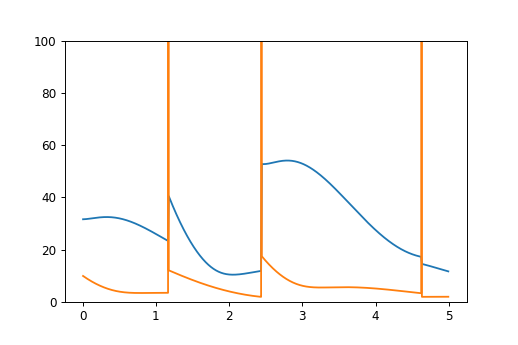

(0, 100)

In [219]:
plt.figure()
plt.plot(t[1:999],S_b[1:999])
plt.plot(t[1:999],DXtot[1:999])
plt.ylim([0,100])

## Noisy
we add Gaussian noise on the observations of the state but on the time

In [249]:
noise_std = 0.05
Xtot_r_noisy = Xtot_r + noise_std*np.hstack((np.random.rand(len(Xtot_r),2),np.zeros((len(Xtot_r),1)))) 

DeltaXtot_noisy = (Xtot_r_noisy[1:]-Xtot_r_noisy[:-1])/(Ttot[1]-Ttot[0])
DXtot_noisy = np.array([np.linalg.norm(p) for p in DeltaXtot_noisy])

In [252]:
def NormSmoothnessBound(x, x_, r):
    Df = [[0, 1, 0], [-k, -b, 0], [0, 0, 1]]
    nDf = np.linalg.norm(Df)
    Integral = np.linalg.norm(x)+np.linalg.norm(x_)
    return (r*nDf*Integral)/(2)

r = 15
S_b_noisy = np.array([SmoothnessBound(Xtot_r_noisy[i],Xtot_r_noisy[i-1],r) for i in range(1,len(Xtot_r_noisy))])

In [253]:
def JumpDetector(Dx,Sb):
    if Dx<=Sb:
        return 0
    else:
        return 1
    
gamma = [JumpDetector(DXtot_noisy[i],S_b_noisy[i]) for i in range(len(DXtot_noisy))]

<IPython.core.display.Javascript object>


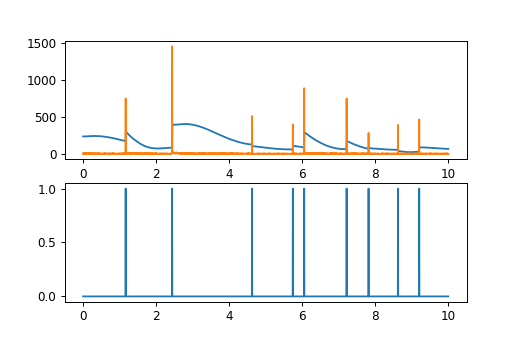

In [257]:
plt.figure()
plt.subplot(211)
plt.plot(t[1:1999],S_b_noisy[1:1999])
plt.plot(t[1:1999],DXtot_noisy[1:1999])
plt.subplot(212)
plt.plot(t[1:1999],gamma[1:1999])
#plt.ylim([0,100])